# Overview 

### Each topic outputs a set of genes with a score. Scanpy.tl.score_genes and the PCa cell signatures from cell2location  paper https://www.nature.com/articles/s41587-021-01139-4 were used to rank cell types within each topic.  The highest ranked genes and cell types per topic were used for futher analysis.

Imports 

In [2]:
import pandas as pd 
import scanpy as sc 
import numpy as np

Load  cell pie output - topics x genes 

In [4]:
iac_path = 'Data/mouse_if_genes_repr.h5ad' 
iac_adata = sc.read(iac_path)

In [5]:
iac_adata

AnnData object with n_obs × n_vars = 17 × 14709

In [6]:
import anndata

In [7]:
## snRNA reference (raw counts)
adata_snrna_raw =anndata.read_h5ad("Data/Mouse_c2l/all_cells_filtered.h5ad")
adata_snrna_raw.var_names_make_unique()
adata_snrna_raw.obs_names_make_unique()
## Cell type annotations
labels = pd.read_csv("Data/Mouse_c2l/snRNA_annotation_astro_subtypes_refined59_20200823_noUnk.csv", index_col=0)

/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
labels = labels.reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs[labels.columns] = labels
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['annotation_1'].isna(), :]

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


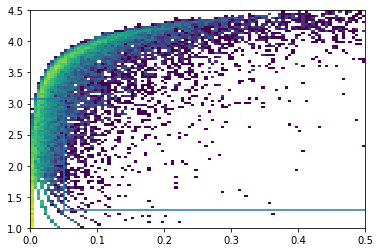

In [10]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0005)
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2);
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1);
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff);

In [11]:
# show the number of selected cells and genes
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(39186, 12470)

In [12]:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)]
#                & np.array(~adata_snrna_raw.var['SYMBOL'].isna())]

In [13]:
# add counts matrix as adata.raw
adata_snrna_raw.raw = adata_snrna_raw

In [14]:
covariate_col_names = 'annotation_1'

inf_aver = adata_snrna_raw.raw.var.copy()
adata_snrna_raw

AnnData object with n_obs × n_vars = 39186 × 12470
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation_1', 'n_genes'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean'

In [15]:
# This function has been copied from cell2location https://github.com/BayraktarLab/cell2location
import anndata
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
# +
def compute_cluster_averages(adata, labels, use_raw=True, layer=None):
    """
    Compute average expression of each gene in each cluster

    Parameters
    ----------
    adata
        AnnData object of reference single-cell dataset
    labels
        Name of adata.obs column containing cluster labels
    use_raw
        Use raw slow in adata.
    layer
        Use layer in adata, provide layer name.

    Returns
    -------
    pd.DataFrame of cluster average expression of each gene

    """

    if layer is not None:
        x = adata.layers[layer]
        var_names = adata.var_names
    else:
        if not use_raw:
            x = adata.X
            var_names = adata.var_names
        else:
            if not adata.raw:
                raise ValueError("AnnData object has no raw data, change `use_raw=True, layer=None` or fix your object")
            x = adata.raw.X
            var_names = adata.raw.var_names

    if sum(adata.obs.columns == labels) != 1:
        raise ValueError("`labels` is absent in adata_ref.obs or not unique")

    all_clusters = np.unique(adata.obs[labels])
    averages_mat = np.zeros((1, x.shape[1]))

    for c in all_clusters:
        sparse_subset = csr_matrix(x[np.isin(adata.obs[labels], c), :])
        aver = sparse_subset.mean(0)
        averages_mat = np.concatenate((averages_mat, aver))
    averages_mat = averages_mat[1:, :].T
    averages_df = pd.DataFrame(data=averages_mat, index=var_names, columns=all_clusters)

    return averages_df


In [16]:
inf_aver = compute_cluster_averages(adata_snrna_raw,'annotation_1',use_raw=False)

In [17]:
inf_aver

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO,Astro_STR,Astro_THAL_hab,Astro_THAL_lat,Astro_THAL_med,Astro_WM,...,Inh_Pvalb,Inh_Sst,Inh_Vip,Micro,Nb_1,Nb_2,OPC_1,OPC_2,Oligo_1,Oligo_2
SYMBOL,,,,,,,,,,,,,,,,,,,,,
Xkr4,0.046185,0.075269,0.058691,0.061303,0.088692,0.000000,0.023256,0.075301,0.103704,0.163636,...,14.383090,16.107809,6.124786,0.063218,2.208888,0.655172,2.190152,0.893333,2.212080,0.946111
Gm1992,0.010040,0.007168,0.013544,0.003831,0.022173,0.024691,0.000000,0.009036,0.007407,0.036364,...,2.685328,3.028126,1.073397,0.006568,0.493334,0.142857,0.397045,0.183333,0.445350,0.188004
Mrpl15,0.122490,0.053763,0.097066,0.068966,0.086474,0.037037,0.069767,0.087349,0.116049,0.068182,...,0.276119,0.262500,0.154129,0.051724,0.102222,0.103448,0.095566,0.093333,0.092985,0.065440
Tcea1,0.100402,0.096774,0.130926,0.095785,0.095344,0.135802,0.069767,0.069277,0.086420,0.081818,...,0.312189,0.260938,0.231193,0.074713,0.093333,0.118227,0.116256,0.176667,0.145187,0.075885
Rgs20,3.514055,3.709675,3.841996,3.724137,1.110864,3.901236,1.465117,1.454821,1.219752,4.031816,...,0.376865,0.532813,0.319266,0.018883,0.137778,1.098522,0.594090,0.133333,0.055465,0.020982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Cytb,0.180723,0.150538,0.117382,0.141762,0.099778,0.123457,0.255814,0.102410,0.083951,0.354545,...,0.417910,0.332813,0.234863,0.064860,0.137778,0.083744,0.159606,0.153333,0.092985,0.089287
Vamp7,0.046185,0.039427,0.049661,0.053640,0.046563,0.074074,0.000000,0.033133,0.044444,0.072727,...,0.089552,0.120312,0.108257,0.021346,0.057778,0.064039,0.084729,0.103333,0.104405,0.072095
Tmlhe,0.267068,0.240143,0.313770,0.241379,0.297117,0.456790,0.186046,0.331325,0.328395,0.100000,...,0.426616,0.475001,0.372478,0.087849,0.106667,0.039409,0.311330,0.316667,0.295269,0.138738


In [18]:
sc.pp.normalize_total(adata_snrna_raw, target_sum=1e4)
sc.pp.log1p(adata_snrna_raw)

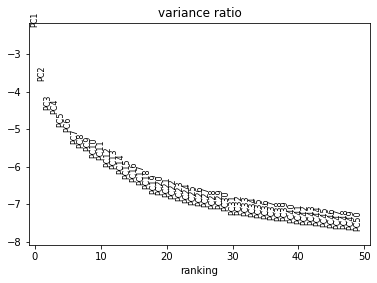

In [19]:
sc.tl.pca(adata_snrna_raw, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_snrna_raw, log=True, n_pcs=50, save='') # scanpy generates the filename automatically


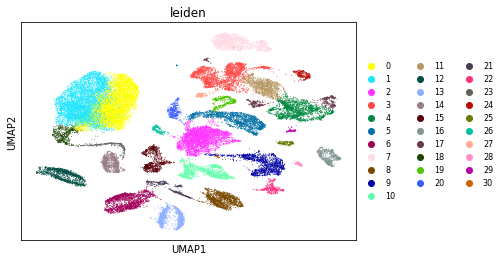

In [20]:
sc.pp.neighbors(adata_snrna_raw, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_snrna_raw)
sc.tl.leiden(adata_snrna_raw, resolution=0.5)
sc.pl.umap(adata_snrna_raw, color=['leiden'], legend_fontsize=8, save='_leiden')

In [21]:
sc.tl.rank_genes_groups(adata_snrna_raw, use_raw=False,groupby='annotation_1', method='wilcoxon')

# The head function returns the top n genes per cluster
top_markers = pd.DataFrame(adata_snrna_raw.uns['rank_genes_groups']['names']).head(5)
print(top_markers)

/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWa

  Astro_AMY Astro_AMY_CTX Astro_CTX Astro_HPC Astro_HYPO Astro_STR  \
0     Wdr17        Slc1a2    Slc1a2    Slc1a2      Trpm3     Prex2   
1    Slc1a2         Wdr17     Wdr17     Wdr17     Slc4a4    Slc1a2   
2    Slc1a3          Gpc5      Gpc5      Gpc5    Pitpnc1     Wdr17   
3      Apoe           Ntm    Slc1a3    Slc1a3      Npas3      Cst3   
4      Gpc5          Apoe      Msi2      Apoe       Apoe       Cpe   

  Astro_THAL_hab Astro_THAL_lat Astro_THAL_med Astro_WM  ... Inh_Pvalb  \
0         Slc4a4          Trpm3          Trpm3    Wdr17  ...     Erbb4   
1            Cpe         Slc4a4         Slc4a4     Msi2  ...     Grip1   
2           Apoe           Gpc5        Pitpnc1     Apoe  ...     Nxph1   
3          Npas3         Atp1a2          Npas3   Slc1a2  ...    Kcnmb2   
4        Sparcl1          Npas3         Atp1a2     Cst3  ...   Galntl6   

  Inh_Sst  Inh_Vip   Micro    Nb_1    Nb_2   OPC_1     OPC_2  Oligo_1  Oligo_2  
0   Grip1   Adarb2  Inpp5d  Zbtb20    Nfib  Lhfpl3   

/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWa

In [22]:
top_markers = pd.DataFrame(adata_snrna_raw.uns['rank_genes_groups']['names']).head(200)

In [23]:
cell_type_signatures = top_markers
cell_type_signatures

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO,Astro_STR,Astro_THAL_hab,Astro_THAL_lat,Astro_THAL_med,Astro_WM,...,Inh_Pvalb,Inh_Sst,Inh_Vip,Micro,Nb_1,Nb_2,OPC_1,OPC_2,Oligo_1,Oligo_2
0,Wdr17,Slc1a2,Slc1a2,Slc1a2,Trpm3,Prex2,Slc4a4,Trpm3,Trpm3,Wdr17,...,Erbb4,Grip1,Adarb2,Inpp5d,Zbtb20,Nfib,Lhfpl3,Fyn,Plekha1,Slc24a2
1,Slc1a2,Wdr17,Wdr17,Wdr17,Slc4a4,Slc1a2,Cpe,Slc4a4,Slc4a4,Msi2,...,Grip1,Nxph1,Nrxn3,Tanc2,Tcf4,Meis2,Xylt1,Sirt2,Fgfr2,Prr5l
2,Slc1a3,Gpc5,Gpc5,Gpc5,Pitpnc1,Wdr17,Apoe,Gpc5,Pitpnc1,Apoe,...,Nxph1,Nrxn3,Grip1,Zfhx3,Dab1,Zbtb20,Tnr,Bcas1,Pcdh9,Plp1
3,Apoe,Ntm,Slc1a3,Slc1a3,Npas3,Cst3,Npas3,Atp1a2,Npas3,Slc1a2,...,Kcnmb2,Kcnc2,Erbb4,Srgap2,Auts2,Tcf4,Dscam,Bcas1os2,Mobp,Pde4b
4,Gpc5,Apoe,Msi2,Apoe,Apoe,Cpe,Sparcl1,Npas3,Atp1a2,Cst3,...,Galntl6,Elavl2,Galntl6,Elmo1,Rbfox1,Nol4,Ptprz1,Tns3,Malat1,Mbp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Nim1k,Pigk,Ston2,Serpine2,Pde7b,Klf12,Fgfr1,Qk,Itpr2,Fam20a,...,3110021N24Rik,Tox3,Limch1,Pitpnc1,Nrg3,Sec63,Gsap,Dock6,Kcna1,Ssh2
196,Atp1b2,Ghr,Arhgap26,Slc7a10,Ncam1,Bcl2,Gm40578,Slc25a18,Abat,Plcd4,...,Luzp1,Nav2,Ptprn,Trem2,Prkg1,Grip1,Rtl4,E130308A19Rik,Tsc22d3,Ppp2r3a
197,St6galnac5,Zhx3,Arhgef12,Frmpd1,Ghr,Hivep3,Ttc28,Xylt1,Asrgl1,Kif21a,...,Srgap3,Tiam1,Mirg,Pmepa1,Fam163a,Cenpf,Trio,Gng12,Prkcq,Jam3
198,Arhgef12,Scg3,Ddah1,Znrf3,A330076C08Rik,Wwtr1,Adamts9,Daam2,Gm29683,Cyp2d22,...,Trpc4,Rims1,Ncoa1,Nav3,Fnbp1l,Chd3,Cald1,Zfp516,Pllp,Tmcc3


Score each cell type within each topic using topic scored ranked genes 

In [24]:
def score_celltypes_per_topic(iac_adata, cell_type_signatures):
    ''' Uses topic score for each gene to rank cell types per topic'''
    
    # Cell type to be scored 
    cell_names = cell_type_signatures.columns.tolist()
    
    # Assign score for each cell type add to adata 
    for i in cell_names: 
        cell_genes = cell_type_signatures[i].values
        sc.tl.score_genes(iac_adata, cell_genes, score_name=i)
    
    return iac_adata 
    

In [25]:
iac_adata = score_celltypes_per_topic(iac_adata, cell_type_signatures)

/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.uniq

/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.uniq

/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.uniq

/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.uniq

/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/user/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.uniq

Create excel file containing ranked cell types and genes per topic with score

In [26]:
def rank_celltype_in_topic(topic_n, adata):
    ''' Ranks cell types based of topic score '''
    print('TOPIC ', topic_n)
    topic_col = adata.obs.iloc[topic_n,1:].sort_values(ascending=False)
    topic_col.columns = ['sc.tl.score_gene']
    return topic_col



In [27]:
def find_top_n_markers(topic_marker_genes, topic, n_genes): 
    ''' Finds all or N top genes per topic '''
    topic_N = topic_marker_genes.iloc[:,[0,(topic+1)]]
    topic_N_ngenes = topic_N.sort_values(by='Topic_'+str(topic), ascending=False)
    topic_N_ngenes.columns = ['Genes', 'Topic score']
    return topic_N_ngenes

In [28]:
import pandas as pd
topic_path = 'Data/marker_genes_mouse_if_repr.csv' 
def load_topic_csv(topic_path):
    # Load csv 
    topic_marker_genes = pd.read_csv(topic_path)
    
    # Add columns 
    topic_names = ['Topic_'+str(i) for i in range(len(topic_marker_genes.columns)-1)]
    column_names = ['Genes']
    column_names.extend(topic_names)
    topic_marker_genes.columns = column_names
    return topic_marker_genes

topic_marker_genes = load_topic_csv(topic_path)

In [29]:
def results_output():
    ''' Creates two excel files to store results: 
    1. ranked_celltypes_per_topic.xlsx
    2. ranked_celltypes_per_topic.xlsx '''

    # Generate ranked / scored cell types and genes per topic 
    celltype_rank_dict = {} 
    top_markers_dict = {} 

    for i in range(len(topic_marker_genes.columns)-1):
        celltype_rank_dict[i] = rank_celltype_in_topic(i,iac_adata)
        top_markers_dict[i] = find_top_n_markers(topic_marker_genes, i, n_genes=5)
    
    # Save to excel
    with pd.ExcelWriter('ranked_celltypes_per_topic_mb_repr.xlsx') as writer:
        for i in range(len(topic_marker_genes.columns)-1): 
            celltype_rank_dict[i].to_excel(writer, sheet_name='topic_' + str(i))

    with pd.ExcelWriter('ranked_genes_per_topic_mb_repr.xlsx') as writer:
        for i in range(len(topic_marker_genes.columns)-1): 
            top_markers_dict[i].to_excel(writer, sheet_name='topic_' + str(i))
    return 





In [30]:
results_output()

TOPIC  0
TOPIC  1
TOPIC  2
TOPIC  3
TOPIC  4
TOPIC  5
TOPIC  6
TOPIC  7
TOPIC  8
TOPIC  9
TOPIC  10
TOPIC  11
TOPIC  12
TOPIC  13
TOPIC  14
TOPIC  15
TOPIC  16
